# Find songs for all files of a bird (or a day of a bird)

In [ ]:
#notebook for testing the search of song in a wav file
## Load everything
%matplotlib inline
import pdb
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy as sp
import socket
import os
import logging
import glob

matplotlib.style.use('ggplot')

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Set up Computer and paths
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)
   
#grab soundtools
from swissknife.streamtools import findsong
from swissknife.bci.core import expstruct as et
import swissknife.streamtools.findbout as fb
from swissknife.threadtools.threadedfunction import threadedFunction

### Define the bird, the day of the recording, and the location of the raw_data
No need for rec and sess_day, those can be entered later

In [2]:
bird_id = 'z007' 
sess_day = '005'
rec = 'a_02_song'
raw_location = 'rw'
raw_data_folder_bird = et.file_names(bird_id)['folders'][raw_location]

#### For instance, here functions for getting all the sessions of a bird

In [3]:
def list_flatten(lists):
    return [t for sublist in lists for l in sublist for t in l]

def all_bird_sessions(raw_folder):
    return list(os.walk(raw_folder))[0][1]

def all_day_wavs(day_folder):
    return glob.glob(os.path.join(day_folder, '*.wav'))

def get_day_files(raw_data_folder_bird, day):
    day_path = os.path.join(raw_data_folder_bird, day)
    logger.info('Getting all wav names for day {}'.format(day_path))
    all_wavs = all_day_wavs(day_path)
    return all_wavs

def get_bird_files(raw_data_folder_bird, only_days=None):
    if only_days:
        all_days = only_days
        logger.info('Only days {}'.format(all_days))
    else:
        all_days = all_bird_sessions(raw_data_folder_bird)
    all_bird_files = [get_day_files(raw_data_folder_bird, day) for day in all_days]
    return [x for sublist in all_bird_files for x in sublist]


In [4]:
only_days = [sess_day]
raw_file_list = get_bird_files(raw_data_folder_bird, only_days=only_days)
all_raw_file_list = [x for x in raw_file_list if 'autobouts' not in x]
all_raw_file_list.sort()

2018-05-04 09:46:19,865 root         INFO     Only days ['005']
2018-05-04 09:46:19,866 root         INFO     Getting all wav names for day /mnt/cube/earneodo/bci_zf/raw_data/z007/005


In [5]:
all_raw_file_list

['/mnt/cube/earneodo/bci_zf/raw_data/z007/005/a_01_song.wav',
 '/mnt/cube/earneodo/bci_zf/raw_data/z007/005/a_02_song.wav']

### Now set to find song (a pattern) in a list of folders, each for one day

In [6]:
## One option is to go through all of the days (sessions) of the bird

#all_days = all_bird_sessions(raw_data_folder_bird)
#all_days.sort()
#len(all_days)

In [7]:
# Screw that, I want the days listed specifically
all_days = ['005']

In [8]:
# create file handler which logs even debug messages
log_f_name = os.path.join(raw_data_folder_bird, 'search_bout_one_day_2_mot_1.log')
fh = logging.FileHandler(log_f_name)
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
print(log_f_name)

/mnt/cube/earneodo/bci_zf/raw_data/z007/search_bout_one_day_2_mot_1.log


### The hi level function to serach for bouts in all the wavs of a session
looks for a stim.par.yml file in the stimulus's folder (..\bci_zf\stim_data\bird\stim_sess\stim.par.yml).
It has to contain the .wav filename of the pattern name, and the parameters for filtering, fft window, thresholds and peak detection.

This runs a search and spits a pandas file and an h5 file with the putative motifs.

In [9]:
def search_bouts_song(bird, sess, stim_name, stim_ver='001'):
    fn = et.file_names(bird, stim_ver)
    stim_par = et.read_yml(os.path.join(fn['folders']['stim'], 'stim.par.yml'))
    
    search_par = stim_par['search_motiff']
    pattern_path = os.path.join(fn['folders']['stim'], search_par['motiff_patterns'][stim_name])
    
    fn_data = et.file_names(bird, sess)
    stream_folder = fn_data['folders']['rw']
    dest_folder = fn_data['folders']['ss']
    et.mkdir_p(dest_folder)
    
    log_f_name = os.path.join(dest_folder, 'search_bout_{}.log'.format(stim_name))
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    fh = logging.FileHandler(log_f_name)
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    
    all_candidates = fb.search_bouts_sess(stream_folder, pattern_path, search_par, 
                                          chunked_specgram=False)
    logger.info('Done collecting all candidates for all files in the folder')
    all_candidates = fb.collect_bouts_waveforms(all_candidates, pattern_path, border_samples=3000)
    all_candidates.to_pickle(os.path.join(dest_folder, '{}_match_cand.pickle'.format(stim_name)))
    logger.info('Saved file, nothing more to do')
    logger.removeHandler(fh)
    fh.flush()
    fh.close()
    return all_candidates



#### This is to search in only one session

2018-05-04 09:46:32,830 bci.core.expstruct DEBUG    Creating directory /mnt/cube/earneodo/bci_zf/ss_data/z007/005
2018-05-04 09:46:32,858 bci.core.expstruct DEBUG    Directory existed, doing nothing
2018-05-04 09:46:32,860 swissknife.streamtools.findbout INFO     will search for pattern in all waves of folder /mnt/cube/earneodo/bci_zf/raw_data/z007/005
2018-05-04 09:46:32,861 swissknife.streamtools.findbout INFO     found 2 wav files
2018-05-04 09:46:32,862 swissknife.streamtools.findbout INFO     searching for pattern in /mnt/cube/earneodo/bci_zf/raw_data/z007/005/a_01_song.wav
2018-05-04 09:47:37,449 swissknife.streamtools.findbout INFO     418195456 samples loaded at 44100 Hz
2018-05-04 09:47:37,452 swissknife.streamtools.findbout INFO     Calling find_the_bouts
2018-05-04 09:47:39,551 swissknife.streamtools.findbout INFO     Begin to get scores (rms, env_corr)
2018-05-04 09:47:40,695 swissknife.streamtools.findbout INFO     Getting the spectral scores
2018-05-04 09:47:40,696 swissk

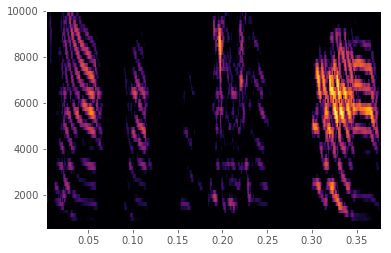

In [10]:
sess_cand = search_bouts_song(bird_id, all_days[0], 'motiff_1')

In [ ]:
plt.plot(all_candidates.waveform.tolist()[22][3000:-3000])

In [ ]:
all_sess_cand = []
for d in all_days[-1:]:
    sess_cand = search_bouts_song(bird_id, d, 'motiff_1')
    all_sess_cand.append(sess_cand)

## run a thread with search in many sessions
- The sessions are in all_days

#### Create a log, if you may

In [ ]:
# create file handler which logs even debug messages
log_f_name = os.path.join(raw_data_folder_bird, 'search_bout_many_days.log')
fh = logging.FileHandler(log_f_name)
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
print(log_f_name)

In [ ]:
[all_days[-1]]

In [ ]:
import pandas as pd
def find_bout_list(bird_id, sess_list, pattern_name):
    sess_cand_list = [search_bouts_song(bird_id, s, pattern_name) for s in sess_list]
    return pd.concat(sess_cand_list)

the_long_search = threadedFunction(args=(find_bout_list, bird_id, [all_days[-1]], 'motiff_0'))
the_long_search.start()


## Debugging and all that jizz

In [ ]:
import swissknife.streamtools.findbout as fb
reload(et)
reload(fb)
reload(sp)

stim_ver = '001'

fn = et.file_names(bird_id, stim_ver)

stim_par = et.read_yml(os.path.join(fn['folders']['stim'], 'stim.par.yml'))

search_par = stim_par['search_motiff']
stim_names = list(search_par['motiff_patterns'].keys())
print(stim_names)
stim_name = 'motiff_0'

search_par['corr_thresh'] = 0.5
search_par['db_cut'] = 60
pattern_path = os.path.join(fn['folders']['stim'], search_par['motiff_patterns'][stim_name])
#stream_path = all_raw_file_list[-10]
#stream_path = '/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-08-06/06-00-01-23.wav'
stream_path = one_file
#stream_path = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/z036/2017-07-10', '06-00-02-11_auto.wav')
candy = fb.search_bouts(stream_path, pattern_path, search_par, chunked_specgram=False, debug=True)


In [ ]:
candy[1].plot(subplots=True)

In [ ]:
allcand = map(lambda x: fb.search_bouts(x, pattern_path, search_par, chunked_specgram=False), all_raw_file_list[0:2])

In [ ]:
pd_cand.to_pickle?

In [ ]:
pd_cand = pd.concat(allcand)

In [ ]:
stream_path = '/mnt/cube/earneodo/bci_zf/raw_data/z036/2017-08-06/06-00-01-23.wav'

In [ ]:
candy['file'] = stream_path

In [ ]:
candy

In [ ]:
pat =WavData(stream_path)
alpat = Chunk(pat).data.flatten()

In [ ]:
for start in candy.start.tolist():
    plt.figure()
    plt.plot(alpat[start:start+30000])

In [ ]:
alpat.samples

In [ ]:
list(search_par['motiff_patterns'].keys())

In [ ]:
fn